In [268]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
from pathlib import Path
gpu_implementation_path = '/home/mt/repos/research.mtne/gpu_implementation'
if gpu_implementation_path not in sys.path:
    sys.path.append(gpu_implementation_path)
gpu_implementation_analysis_path = '/home/mt/repos/research.mtne/gpu_implementation/analysis'
if gpu_implementation_analysis_path not in sys.path:
    sys.path.append(gpu_implementation_analysis_path)
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import utils
from metrics import *

# from esmt import TrainingState

main_log_dir = Path(gpu_implementation_path) / "logs"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [269]:
experiments = {
    'ST-zaxxon': {'dir': main_log_dir / 'ST-zaxxon-5000', 'type': 'ST'},
    'ST-riverraid': {'dir': main_log_dir / 'ST-riverraid-5000', 'type': 'ST'},
    'MT': {'dir': main_log_dir / 'MT-zaxxon-riverraid-5000', 'type': 'MT' },
    'ST-riverraid-zaxxon': {'dir': main_log_dir / 'evaluate_riverraid_using_zaxxon_model', 'type': 'ST'},
    'ST-zaxxon-riverraid': {'dir': main_log_dir / 'evaluate_zaxxon_using_riverraid_model', 'type': 'ST'},
    
}

In [270]:
for exp_name, exp in experiments.items():
    exp['cfg'] = utils.get_config(exp)
    exp['rewards'] = utils.get_rewards(exp)

/home/mt/repos/research.mtne/gpu_implementation/logs/ST-riverraid-5000
/home/mt/repos/research.mtne/gpu_implementation/logs/evaluate_riverraid_using_zaxxon_model
/home/mt/repos/research.mtne/gpu_implementation/logs/MT-zaxxon-riverraid-5000
/home/mt/repos/research.mtne/gpu_implementation/logs/evaluate_zaxxon_using_riverraid_model
/home/mt/repos/research.mtne/gpu_implementation/logs/ST-zaxxon-5000


In [271]:
experiments['ST-riverraid-zaxxon']['rewards'].head()

,ST-riverraid_rewards,ST-riverraid_elite
iteration,,
0,1114.114014,960.849976
1,988.072021,744.299988
2,1198.521973,1469.449951
3,1205.734009,1379.099976
4,1234.540039,1848.800049


In [273]:
cfg = experiments['MT']
game_idx = 0
iterations = range(1, 200)
bin_size = 100
epsilon = 0.0001
dkl_game_idx0 = pd.DataFrame.from_dict({
    'dkl': [utils.compute_dkl(cfg, game_idx, i, bin_size, epsilon) for i in iterations]
})

In [274]:
cfg = experiments['MT']
game_idx = 1
iterations = range(1, 200)
bin_size = 100
epsilon = 0.0001
dkl_game_idx1 = pd.DataFrame.from_dict({
    'dkl': [utils.compute_dkl(cfg, game_idx, i, bin_size, epsilon) for i in iterations]
})

In [275]:
cfg = experiments['ST-riverraid-zaxxon']
game_idx = 0
iterations = range(1, 200)
bin_size = 100
epsilon = 0.0001
st_riverraid_zaxxon = pd.DataFrame.from_dict({
    'dkl': [utils.compute_dkl(cfg, game_idx, i, bin_size, epsilon) for i in iterations]
})

In [276]:
cfg = experiments['ST-zaxxon']
game_idx = 0
iterations = range(1, 200)
bin_size = 100
epsilon = 0.0001
st_zaxxon = pd.DataFrame.from_dict({
    'dkl': [utils.compute_dkl(cfg, game_idx, i, bin_size, epsilon) for i in iterations]
})

In [277]:
dkl = pd.DataFrame.from_dict({
    'dkl_game0': dkl_game_idx0.dkl,
#    'dkl_game1': dkl_game_idx1.dkl,
    'dkl_st_zaxxon': st_zaxxon.dkl,
    'dkl_st_riverraid_zaxxon': st_riverraid_zaxxon.dkl
})

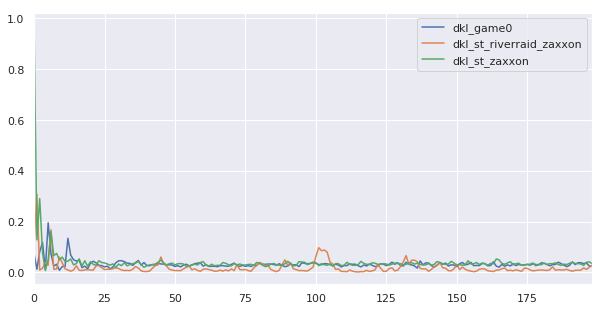

In [278]:
sns.set(rc={'figure.figsize': (10, 5)})
dkl.plot()